In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import glob
import os

# Hyper params

In [2]:
batch_size = 64
epochs = 5
learing_rate = 1e-4
label_map = {
    'neg': 0,
    'pos': 1
}

model_type = 'use'

# Data Loading & Understanding

In [3]:
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    'imdb_reviews', split=['train', 'test[:50]', 'test[50:]'],
      as_supervised=True, with_info=True, data_dir='data'
)

In [4]:
train_df = tfds.as_dataframe(train_ds, ds_info)
train_df['len'] = train_df['text'].apply(lambda x: len(x))

<AxesSubplot:xlabel='label', ylabel='count'>

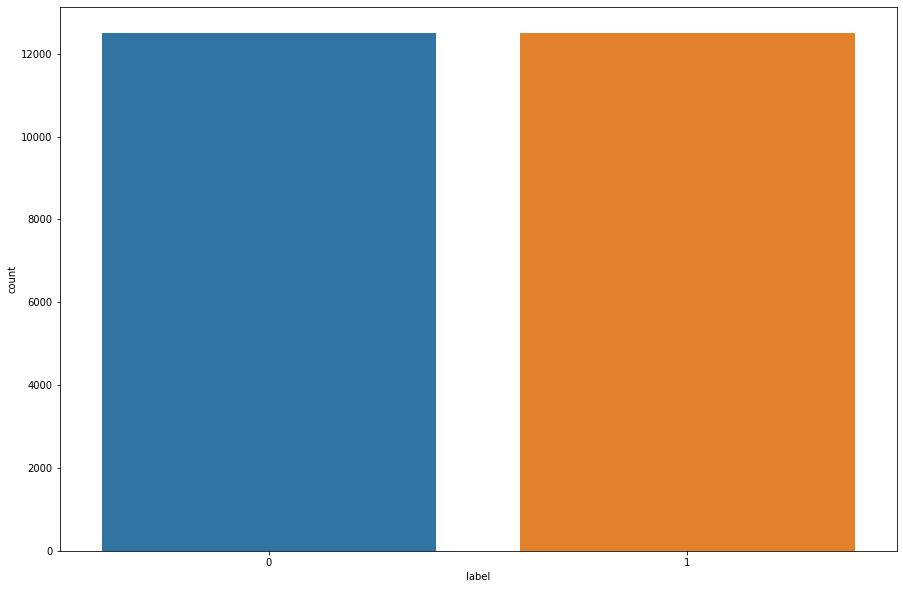

In [5]:
plt.figure(figsize=(15, 10))
sns.countplot(data=train_df, x='label')

<AxesSubplot:xlabel='label', ylabel='len'>

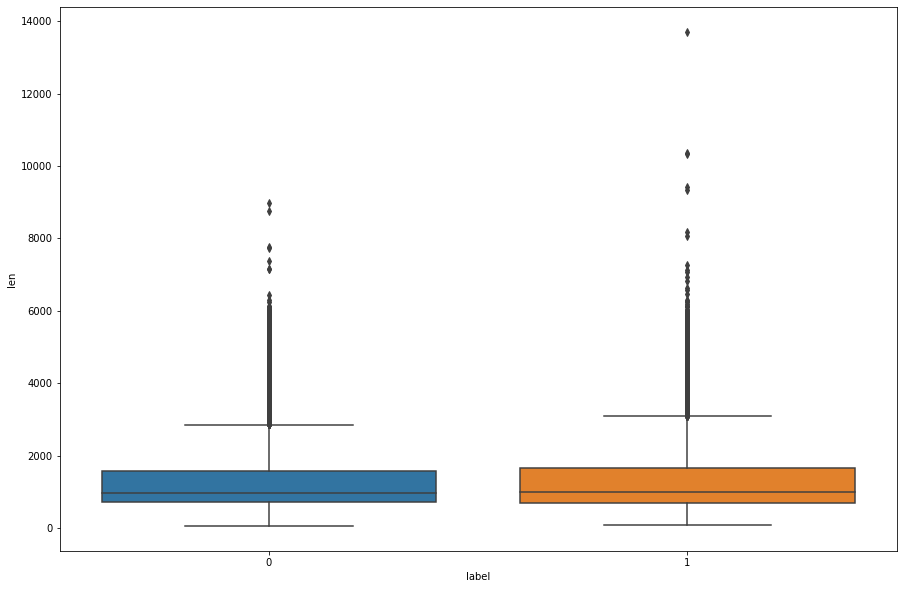

In [6]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=train_df, y='len', x='label')

# Build Data Pipeline

In [7]:
train_dataset = train_ds.shuffle(1000).map(lambda x, y: (x, tf.one_hot(y, 2))).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_ds.batch(batch_size).map(lambda x, y: (x, tf.one_hot(y, 2))).prefetch(tf.data.experimental.AUTOTUNE)

# Build model

In [8]:
if model_type == 'base':
    encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=1000
    )

    encoder.adapt(train_dataset.map(lambda text, label: text))

    vocab = np.array(encoder.get_vocabulary())
    vocab[:20]

    encoded_example = encoder(next(iter(train_dataset.take(1)))[0])[:3].numpy()
    encoded_example

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(1, dtype=tf.string),
        encoder,
        tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(2, activation='softmax'),
    ])
else:
    use = hub.KerasLayer(
        'https://tfhub.dev/google/universal-sentence-encoder/4', trainable=True,
        input_shape=[], dtype=tf.string,
    )

    model = tf.keras.Sequential([
        use,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

In [9]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 256,929,666
Trainable params: 256,929,666
Non-trainable params: 0
_________________________________________________________________


# Train model

In [10]:
history = model.fit(
    train_dataset, epochs=epochs, validation_data=test_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy')]
)

Epoch 1/5
391/391 [==============================] - 93s 238ms/step - loss: 0.4561 - accuracy: 0.8086 - val_loss: 0.3170 - val_accuracy: 0.8653
Epoch 2/5
391/391 [==============================] - 91s 233ms/step - loss: 0.2409 - accuracy: 0.9054 - val_loss: 0.2842 - val_accuracy: 0.8802
Epoch 3/5
391/391 [==============================] - 89s 227ms/step - loss: 0.1256 - accuracy: 0.9578 - val_loss: 0.2973 - val_accuracy: 0.8848
Epoch 4/5
391/391 [==============================] - 88s 226ms/step - loss: 0.0465 - accuracy: 0.9883 - val_loss: 0.3392 - val_accuracy: 0.8839


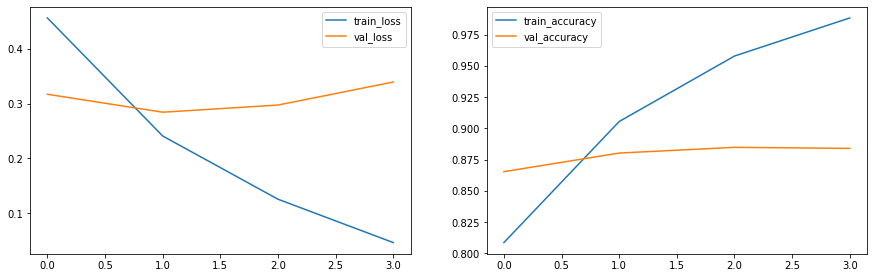

In [11]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(222)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [12]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.15916197, 0.840838  ]], dtype=float32)

# Evaluate model

In [20]:
from scikitplot.metrics import plot_confusion_matrix, plot_precision_recall, plot_roc
from sklearn.metrics import classification_report, matthews_corrcoef

In [14]:
preds = model.predict(test_dataset, verbose=True)
labels = np.concatenate([y for x, y in test_dataset], axis=0).argmax(axis=1)

390/390 [==============================] - 19s 48ms/step


In [24]:
print(classification_report(labels, preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88     12474
           1       0.87      0.91      0.89     12476

    accuracy                           0.88     24950
   macro avg       0.88      0.88      0.88     24950
weighted avg       0.88      0.88      0.88     24950



In [25]:
print(matthews_corrcoef(labels, preds.argmax(axis=1)))

0.7686520194857743


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

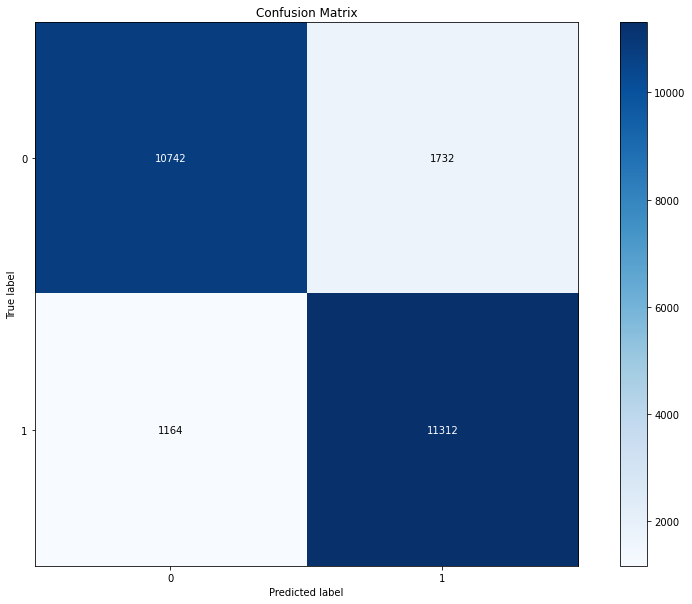

In [15]:
plot_confusion_matrix(labels, preds.argmax(axis=1), figsize=(15, 10))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

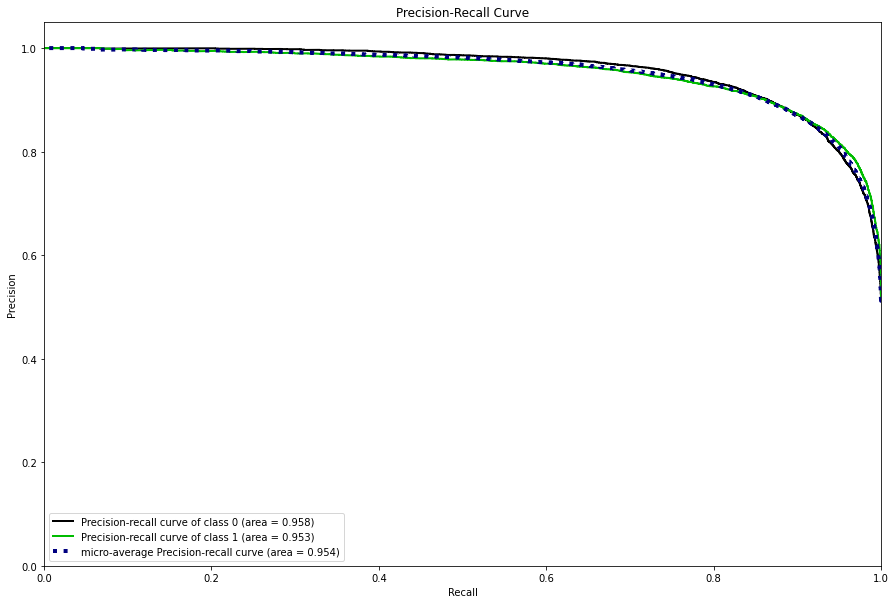

In [16]:
plot_precision_recall(labels, preds, figsize=(15, 10))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

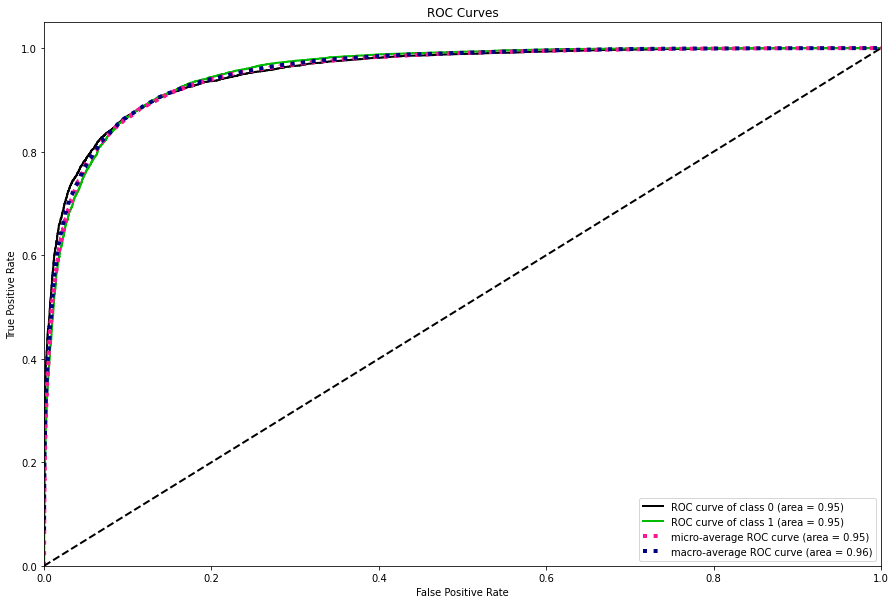

In [17]:
plot_roc(labels, preds, figsize=(15, 10))

# Save model as saved model

In [18]:
tf.saved_model.save(model, 'outputs/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: outputs/assets


INFO:tensorflow:Assets written to: outputs/assets


In [19]:
saved_model = tf.saved_model.load('outputs/')